In [2]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset
from strategies import LSTM_Strategy, Rebalancing_Strategy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2024-05-10 20:53:20.123810: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 20:53:20.129401: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 20:53:20.210677: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 20:53:21.507668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
USD = Asset.make_USD()
BTC = Asset('BTC')
#BTC.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2021-06-01'), date_to = tmpstemp('2024-03-31'))
ETH = Asset('ETH')
#ETH.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2021-06-01'), date_to = tmpstemp('2024-03-31'))
USDT = Asset('USDT')
#USDT.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2021-06-01'), date_to = tmpstemp('2024-03-31'))

In [4]:
naive_LSTM = LSTM_Strategy(model_input_length = 15)
date_from = tmpstemp('2022-01-01')
x_train, y_train, train_idx, x_val, y_val, val_idx = naive_LSTM.train_val_split_scale(BTC.history.loc[date_from:])

rebalncer = Rebalancing_Strategy(target_allocations = {'USD':0.5, 'BTC':0.5})

In [5]:
hidden_size = 50
dropout = 0.2
learning_rate = 0.0005

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]), name = 'input')

LSTM1 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM1' )(input_layer)
LSTM1 = Dropout(dropout)(LSTM1)

LSTM2 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM2' )(LSTM1)
LSTM2 = Dropout(dropout)(LSTM2)

LSTM3 = LSTM(units = 50, activation='tanh', name = 'LSTM3' )(LSTM2)
LSTM3 = Dropout(dropout)(LSTM3)
'''
hidden1 = Dense(hidden_size, activation='relu', name='hidden_layer1')(LSTM3)
hidden1 = Dropout(dropout)(hidden1)
'''

# Create output layer
out = Dense(1, activation='linear', name = 'Regression_layer')(LSTM3)
model = Model(inputs=[input_layer], outputs=out)

model.compile(optimizer=Adam(learning_rate),
              loss=keras.losses.MeanSquaredError,
              metrics=[keras.losses.MeanSquaredError])
naive_LSTM.model = model
#naive_LSTM.model.summary()

#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

naive_LSTM.model.fit([x_train], y_train, 
          validation_data=([x_val], y_val),
          epochs=20, batch_size=64,
          callbacks=[early_stopping])

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0439 - mean_squared_error: 0.0438 - val_loss: 0.0858 - val_mean_squared_error: 0.1071
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0112 - val_mean_squared_error: 0.0147
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0306 - val_mean_squared_error: 0.0389
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0113 - val_mean_squared_error: 0.0144
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0040 - val_mean_squared_error: 0.0049
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0052 - val_mean_squared_error: 0.0061
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0040 - val_mean_square

In [6]:
my_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
my_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

buy_n_hold_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
buy_n_hold_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

rebal_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
rebal_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

In [7]:
def execute_suggestions(suggestions, portfolio, today_date):
    for ticker in suggestions.index:
        portfolio.update_transactions(ticker = str(ticker),
                                    qty =  suggestions['change_in_size'].loc[ticker],
                                    transaction_date = today_date,
                                    note =  suggestions['note'].loc[ticker])

pred_df = pd.DataFrame(data=[],
                        columns = ['Predicted price'],
                        index = pd.DatetimeIndex([], name='date_time'))

#Find record in BTC history that is closest to the origin date of the portfolio
first_index = BTC.history.index.get_indexer([my_portfolio.orig_date], method='nearest')[0] + 1
first_date = BTC.history.index[first_index]

alloc_exp = []
alloc_rebal = []
alloc_bnh = []
for today in BTC.history.index[first_index:-2]:
    tmr = today + tmpdelta(days=1)
    alloc_exp.append(my_portfolio.get_hist_positions(today)['allocation'].loc['BTC'])
    today_data = BTC.history['close'].\
                        loc[today-tmpdelta(days=(naive_LSTM.input_span-1)):today]
    new_pred = naive_LSTM.predict_one(today_data)
    pred_df = pd.concat([pred_df, new_pred], axis = 0)
    suggestion = naive_LSTM.make_suggestion(today, my_portfolio)
    execute_suggestions(suggestion, my_portfolio, today)

    alloc_rebal.append(rebal_portfolio.get_hist_positions(today)['allocation'].loc['BTC'])
    rebal_suggest = rebalncer.make_suggestion(today , rebal_portfolio)
    execute_suggestions(rebal_suggest, rebal_portfolio, today)

    alloc_bnh.append(buy_n_hold_portfolio.get_hist_positions(today)['allocation'].loc['BTC'])

my_portfolio.update_value(up_to=pred_df.index[-1])
buy_n_hold_portfolio.update_value(up_to=pred_df.index[-1])
rebal_portfolio.update_value(up_to=pred_df.index[-1])

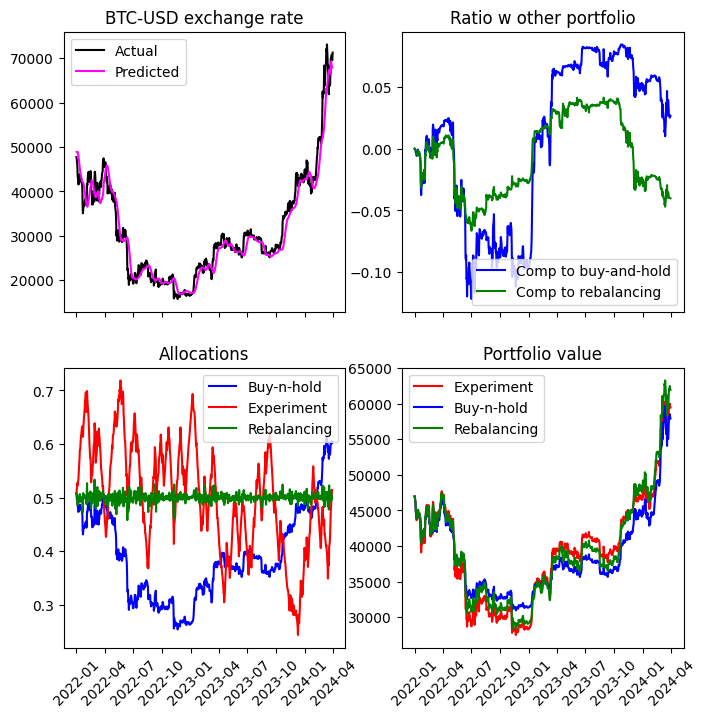

In [8]:
# Plot the results
fig, ax = plt.subplots(2, 2, sharex = True)
fig.set_figheight(8)
fig.set_figwidth(8)
actual_df = BTC.history.loc[first_date:]
ax[0,0].plot(actual_df.index, actual_df['close'], color = 'black', label = 'Actual')
ax[0,0].plot(pred_df.index, pred_df['Predicted price'], color = 'magenta', label = 'Predicted')
ax[0,0].legend()
ax[0,0].set_title('BTC-USD exchange rate')
for tick in ax[0,0].get_xticklabels():
        tick.set_rotation(45)

ax[0,1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - buy_n_hold_portfolio.value['value'])/buy_n_hold_portfolio.value['value'], color = 'blue', label = 'Comp to buy-and-hold')
ax[0,1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - rebal_portfolio.value['value'])/rebal_portfolio.value['value'], color = 'green', label = 'Comp to rebalancing')
ax[0,1].legend()
ax[0,1].set_title('Ratio w other portfolio')
for tick in ax[0,1].get_xticklabels():
        tick.set_rotation(45)

ax[1,0].plot(buy_n_hold_portfolio.value.index[:-1], alloc_bnh, color = 'blue', label = 'Buy-n-hold')
ax[1,0].plot(my_portfolio.value.index[:-1], alloc_exp, color = 'red', label = 'Experiment')
ax[1,0].plot(rebal_portfolio.value.index[:-1], alloc_rebal, color = 'green', label = 'Rebalancing')
ax[1,0].legend()
ax[1,0].set_title('Allocations')
for tick in ax[1,0].get_xticklabels():
        tick.set_rotation(45)

ax[1,1].plot(my_portfolio.value.index, my_portfolio.value['value'], color = 'red', label = 'Experiment')
ax[1,1].plot(buy_n_hold_portfolio.value.index, buy_n_hold_portfolio.value['value'], color = 'blue', label = 'Buy-n-hold')
ax[1,1].plot(rebal_portfolio.value.index, rebal_portfolio.value['value'], color = 'green', label = 'Rebalancing')
ax[1,1].legend()
ax[1,1].set_title('Portfolio value')
for tick in ax[1,1].get_xticklabels():
        tick.set_rotation(45)

In [ ]:
def cross_val_percentages(num_blocks=5, split_ratio=0.8):
    '''
    Creates cross validation block percentiles for both the train and validation sets
    based off the number of blocks and split ratios identified.
    '''
    # creating percentile boundaries for train and validation blocks
    val_area = 1- (1-split_ratio) * 1/num_blocks
    train_block = (1-split_ratio) * 1/num_blocks
    train_blocks_boundaries = [(val_area*i/num_blocks, val_area*(i+1)/num_blocks) for i in range(num_blocks)]
    val_blocks_boundaries = [(val_block[1], val_block[1] + train_block ) for val_block in train_blocks_boundaries]
    print("Train blocks: ", train_blocks_boundaries)
    print("Validation blocks: ", val_blocks_boundaries)
    return train_blocks_boundaries, val_blocks_boundaries

In [ ]:
cross_val_percentages(5, 0.7)

Train blocks:  [(0.0, 0.188), (0.188, 0.376), (0.376, 0.564), (0.564, 0.752), (0.752, 0.9399999999999998)]
Validation blocks:  [(0.188, 0.248), (0.376, 0.436), (0.564, 0.624), (0.752, 0.812), (0.9399999999999998, 0.9999999999999999)]


([(0.0, 0.188),
  (0.188, 0.376),
  (0.376, 0.564),
  (0.564, 0.752),
  (0.752, 0.9399999999999998)],
 [(0.188, 0.248),
  (0.376, 0.436),
  (0.564, 0.624),
  (0.752, 0.812),
  (0.9399999999999998, 0.9999999999999999)])

In [ ]:
def create_validation_blocks(df, split_feature, blocks=5, split=0.8):
    '''
    Function that orders and ranks a df based on a specified feature, 
    and then splits it into equal train and validation blocks based off
    the specified number of blocks and split percent.
    Returns a list of tuples for the train and validation datasets.
    '''
    # defining the window feature for splitting
    window_spec = W.partitionBy().orderBy(split_feature)

    # creating a rank column for ordered df
    ranked_df = df.withColumn("rank", f.percent_rank().over(window_spec))
    
    # creating cross validation percentiles
    train_blocks, val_blocks = cross_val_percentages(blocks, split)

    # Assemble tuples of train and val datasets for cross-validations
    val_train_sets = []
    for train_b, val_b in zip(train_blocks, val_blocks):
        val_train_sets.append((
                                ranked_df.where(f"rank <= {train_b[1]} and rank >= {train_b[0]}").drop('rank')
                                , ranked_df.where(f"rank > {val_b[0]} and rank <= {val_b[1]}").drop('rank')
                                ))
    return val_train_sets